The purpose of this notebook is to generate the figures for the thesis.

## Setup

Next, we import some required packages and our own modules.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

from torch import nn

from modules.utils import save_model, compare_hedgers, compare_strategy
from modules.market_impact import ZeroImpact, FixedImpact
from modules.transaction_cost import ZeroCost
from modules.risk_measure import AverageValueAtRisk
from modules.derivative import EuropeanOption
from modules.black_scholes import BlackScholesModel, BlackScholesHedger, compare_to_black_scholes_hedger
from modules.bachelier import BachelierModel, BachelierHedger, BachelierHedgerFixedImpact
from modules.deep_hedger import DeepHedger, SimpleDeepHedger

figure_path = 'figures/'

If a GPU is available, we would like to use the GPU to speed up the training process. \\
Unfortunately, for some reason, training with the GPU is slower than without! \\
For this reason we will use the CPU for now!

In [2]:
# device settings
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cpu


## Deep Hedging in the Black-Scholes Model

In [3]:
# define parameters
d = 1  # number of hedging instruments 
T = 30/365  # maturity
N = 30  # time discretization
dt = T/N  # time step

# Black-Scholes model parameters
s0 = (100.0)  # inital value(s)
sigma = 0.2  # volatility
model = BlackScholesModel(initial_value=s0, sigma=sigma, dt=dt, device=my_device)

# derivative to hedge
call = True
strike = s0 
derivative = EuropeanOption(call=call, strike=strike, maturity=T)
price = None

q = BlackScholesHedger(n_dim=d, n_steps=N, model=model, derivative=derivative, sigma=sigma).price().item()
#print('The risk neutral price is given by {:.4f}.'.format(q))

# risk measure
alpha = 0.5
risk_measure = AverageValueAtRisk(alpha=alpha)

# market impact model
lambd = 0.0
market_impact = ZeroImpact()

# transaction cost model
c = 0.0
transaction_cost = ZeroCost()

# validation samples
validation_samples = 1000000

In [4]:
path = 'saved_models/black_scholes_deep_hedging'  # path to saved models
file_name = 'deep_hedger_bs'

deep_hedger = DeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
deep_hedger.load_state_dict(torch.load('{}/{}.pth'.format(path, file_name)), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['initial_value'])

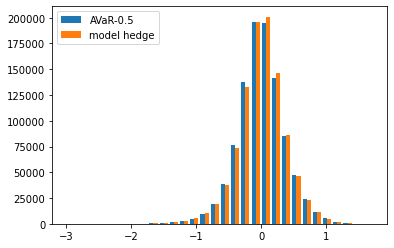

In [5]:
figure_file_name = 'black_scholes_pnl.pdf'

compare_to_black_scholes_hedger(deep_hedger, derivative=derivative, sigma=sigma,
                                risk_measure=risk_measure, n_samples=validation_samples, price=q, device=my_device,
                                labels=['AVaR-0.5', 'model hedge'], file_name=figure_path+figure_file_name)

## Deep Hedging with a simple network structure

In [6]:
path = 'saved_models/black_scholes_deep_hedging'  # path to saved models
file_name = 'simple_hedger_bs'

simple_hedger = SimpleDeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
simple_hedger.load_state_dict(torch.load('{}/{}.pth'.format(path, file_name)), strict=False)

<All keys matched successfully>

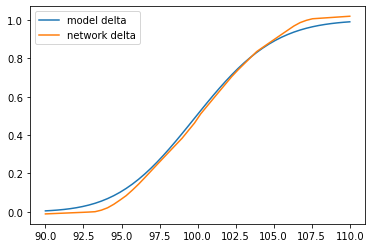

In [7]:
figure_file_name = 'black_scholes_strategy_comparison.pdf'

black_scholes_hedger = BlackScholesHedger(n_dim=d, n_steps=N, model=model, derivative=derivative, sigma=sigma,
                                          market_impact=market_impact, transaction_cost=transaction_cost)
compare_strategy(hedgers=[black_scholes_hedger, simple_hedger], labels=['model delta', 'network delta'], n_step=15, 
                 file_name=figure_path+figure_file_name)

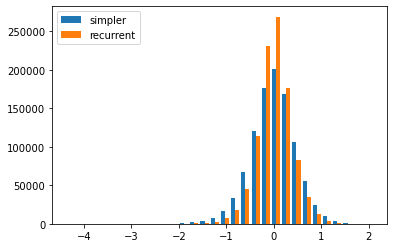

In [8]:
figure_file_name = 'black_scholes_simple_vs_recurrent.pdf'

compare_hedgers(hedgers=[simple_hedger, deep_hedger], model=model, derivative=derivative,
                labels=['simpler', 'recurrent'], n_samples=validation_samples, price=q, file_name=figure_path+figure_file_name)

## Deep Hedging with different risk preferences

In [9]:
# risk measure
alpha = 0.01
risk_measure = AverageValueAtRisk(alpha=alpha)

In [10]:
path = 'saved_models/black_scholes_deep_hedging'  # path to saved models
file_name = 'risk_averse_hedger_bs'

risk_averse_hedger = DeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
risk_averse_hedger.load_state_dict(torch.load('{}/{}.pth'.format(path, file_name)), strict=False)

<All keys matched successfully>

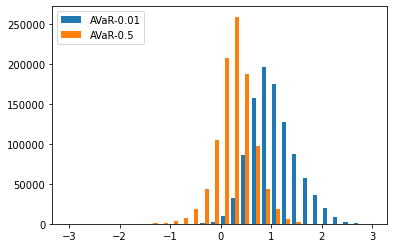

In [11]:
figure_file_name = 'risk_preference_pnl.pdf'

hedgers = [risk_averse_hedger, deep_hedger]
labels = ['AVaR-0.01', 'AVaR-0.5']
risk_measures = [AverageValueAtRisk(alpha=0.01), AverageValueAtRisk(alpha=0.5)]
table_labels = ['Realized AVaR-0.01', 'Realized AVaR-0.5']

risk_adjusted_p_0 = risk_averse_hedger.price(derivative=derivative, risk_measure=risk_measure, n_samples=validation_samples)
p_0 = deep_hedger.price(derivative=derivative, risk_measure=AverageValueAtRisk(alpha=0.5), n_samples=validation_samples)
prices = [risk_adjusted_p_0, p_0]

compare_hedgers(hedgers=hedgers, model=model, derivative=derivative, price=prices,
                labels=labels, n_samples=validation_samples, file_name=figure_path+figure_file_name)

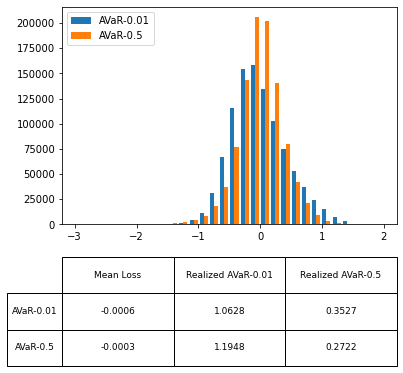

In [12]:
figure_file_name = 'risk_preference_table.pdf'

compare_hedgers(hedgers=hedgers, model=model, derivative=derivative, price=q,
                risk_measure=risk_measures, n_samples=validation_samples,
                labels=labels, table_labels=table_labels, table=True,
                file_name=figure_path+figure_file_name)

## Deep Hedging in the Bachelier Model with permanent price impact

In [13]:
# define parameters
d = 1  # number of hedging instruments 
T = 30/365  # maturity
N = 30  # time discretization
dt = T/N  # time step

# Bachelier model parameters
s0 = (100.0)  # inital value(s)
sigma = 0.2  # volatility
model = BachelierModel(initial_value=s0, sigma=sigma, dt=dt, device=my_device)

# derivative to hedge
call = True
strike = s0 
derivative = EuropeanOption(call=call, strike=strike, maturity=T)
price = None

# risk neutral price
q = BachelierHedger(n_dim=d, n_steps=N, model=model, derivative=derivative, sigma=sigma).price().item()

# risk measure
alpha = 0.5
risk_measure = AverageValueAtRisk(alpha=alpha)

# market impact model
lambd = 1.0
market_impact = FixedImpact(lambd=lambd)

# transaction cost model
c = 0.0
transaction_cost = ZeroCost()

In [14]:
path = 'saved_models/deep_hedging_with_impact'  # path to saved models
file_name = 'deep_hedger_impact_bachelier'

deep_hedger_impact = DeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
deep_hedger_impact.load_state_dict(torch.load('{}/{}.pth'.format(path, file_name)), strict=False)

<All keys matched successfully>

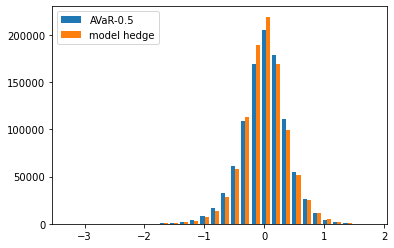

In [15]:
figure_file_name = 'impact_pnl.pdf'

bachelier_hedger = BachelierHedgerFixedImpact(n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost, 
                                             sigma=sigma, lambd=lambd)
compare_hedgers(hedgers=[deep_hedger_impact, bachelier_hedger], model=model, derivative=derivative,
                n_samples=validation_samples, price=q, labels=['AVaR-0.5', 'model hedge'], file_name=figure_path+figure_file_name)

## Deep Hedging with a simple structure in the presence of market impact

In [16]:
# risk measure
alpha = 0.01
risk_measure = AverageValueAtRisk(alpha=alpha)

# market impact model
lambd = 1.0
market_impact = FixedImpact(lambd=lambd)

# transaction cost model
c = 0.0
transaction_cost = ZeroCost()

In [17]:
path_simple = 'saved_models/deep_hedging_with_impact'  # path to saved models
file_name_simple = 'simple_hedger_impact_bachelier'

simple_hedger_impact = SimpleDeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
simple_hedger_impact.load_state_dict(torch.load('{}/{}.pth'.format(path_simple, file_name_simple)), strict=False)

path_recurrent = 'saved_models/deep_hedging_with_impact'  # path to saved models
file_name_recurrent = 'recurrent_hedger_impact_bachelier'

recurrent_hedger_impact = DeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
recurrent_hedger_impact.load_state_dict(torch.load('{}/{}.pth'.format(path_recurrent, file_name_recurrent)), strict=False)

<All keys matched successfully>

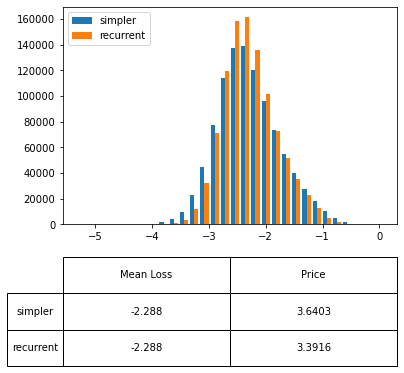

In [18]:
figure_file_name = 'impact_simple_vs_recurrent.pdf'

hedgers=[simple_hedger_impact, recurrent_hedger_impact]
labels = ['simpler', 'recurrent']
prices = None
risk_measures = risk_measure
table_labels = ['Price']

compare_hedgers(hedgers=hedgers, model=model, derivative=derivative,
                risk_measure=risk_measures, n_samples=validation_samples, price=prices, 
                labels=labels, table_labels=table_labels, table=True, file_name=figure_path+figure_file_name)